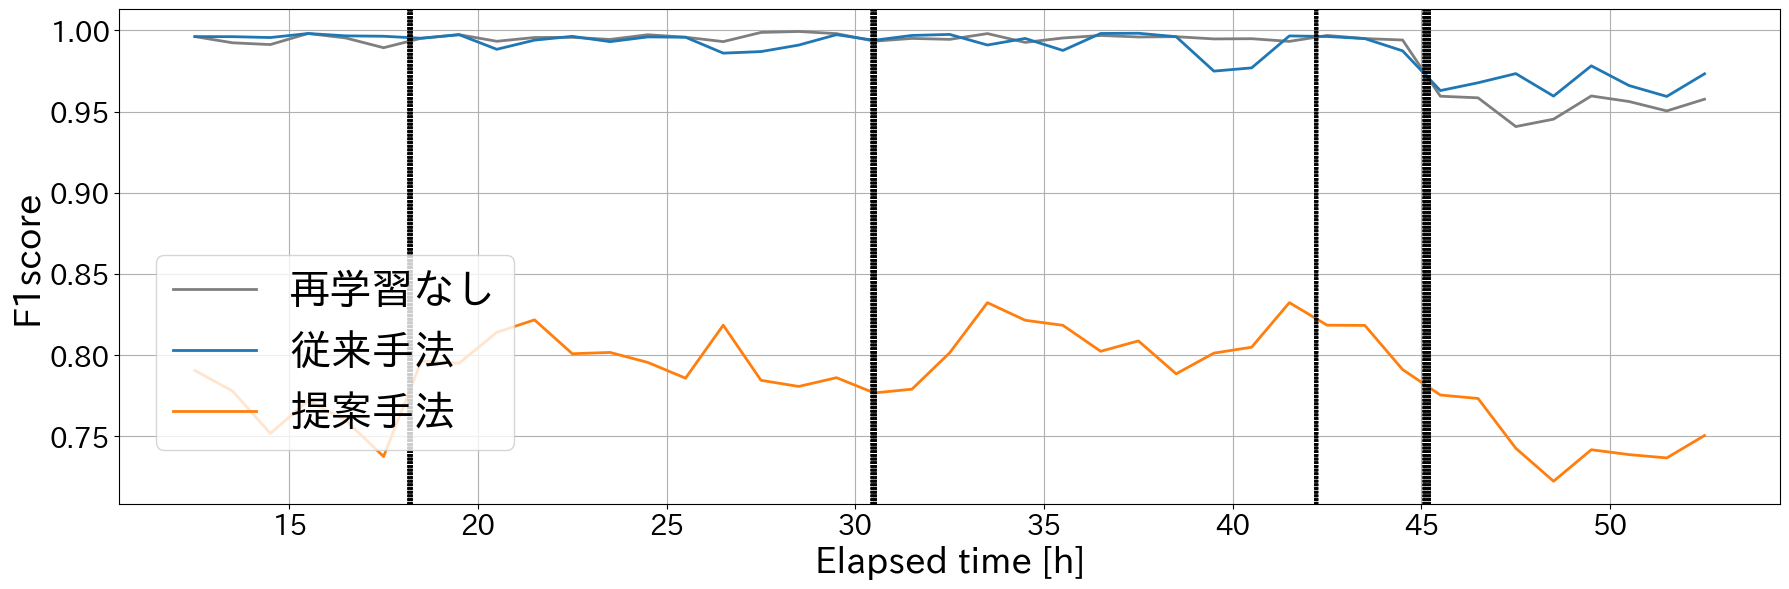

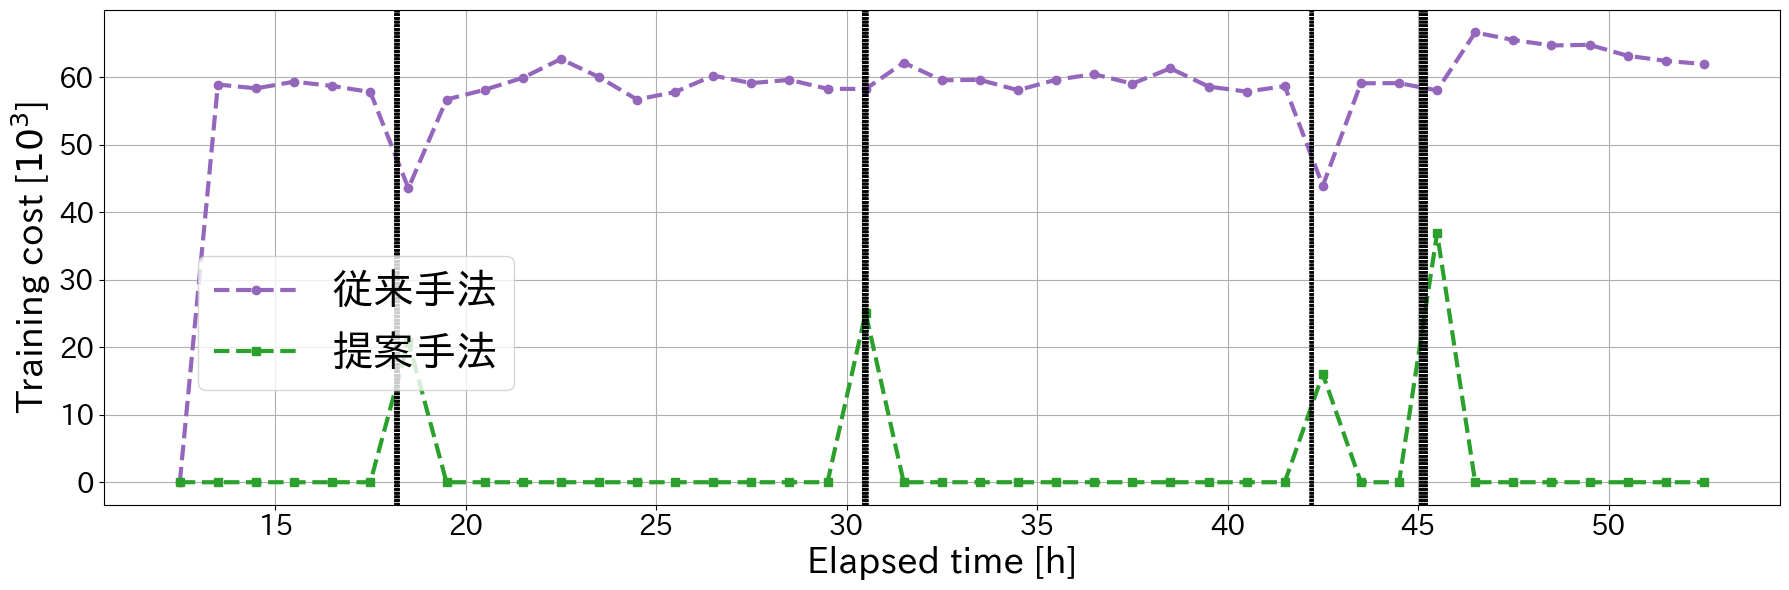

In [11]:
import os
import pandas as pd
import japanize_matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from datetime import timedelta, datetime
import glob

#-------------------------------------------------------------------#
# 定数定義
metrix = "f1_score"
nt_dir_path = "/mnt/nas0/g005/murasemaru/exp/MTG_20250722/nt"
st_dir_path = "/mnt/nas0/g005/murasemaru/exp/MTG_20250722/stz"
st_epochs = 30
dy_dir_path = "/mnt/nas0/g005/murasemaru/exp/MTG_20250722/dy_old"
dy_epochs = 1
start_date = '2022-01-10 15:00:00'
#-------------------------------------------------------------------#

# 出力先ディレクトリの設定
output_dir = f"{dy_dir_path}/res_img"
os.makedirs(output_dir, exist_ok=True)
output_path = f"{output_dir}/{metrix}.png"
start_date = datetime.strptime(start_date, '%Y-%m-%d %H:%M:%S')

# 評価データの読み込みと前処理
nt_eval_data = pd.read_csv(f"{nt_dir_path}/res_eval.csv").rename(columns={metrix: "nt"})
st_eval_data = pd.read_csv(f"{st_dir_path}/res_eval.csv").rename(columns={metrix: "static"})
dy_eval_data = pd.read_csv(f"{dy_dir_path}/res_eval.csv").rename(columns={metrix: "dynamic"})

eval_data = pd.concat(
    [nt_eval_data.loc[:, ["daytime", "nt"]],
     st_eval_data.loc[:, ["static"]],
     dy_eval_data.loc[:, ["dynamic"]]],
    axis=1
)
eval_data['daytime'] = pd.to_datetime(eval_data['daytime'])

# 訓練データ（静的）読み込み
st_tr_data = pd.read_csv(f"{st_dir_path}/res_train_m0.csv")
st_tr_data["daytime"] = pd.to_datetime(st_tr_data["daytime"])

# 訓練データ（動的）：複数モデルを自動検出して統合
dy_model_paths = sorted(glob.glob(f"{dy_dir_path}/res_train_m*.csv"))
dy_tr_data_list = []
for path in dy_model_paths:
    df = pd.read_csv(path)
    df["daytime"] = pd.to_datetime(df["daytime"])
    dy_tr_data_list.append(df)
dy_tr_data = pd.concat(dy_tr_data_list, axis=0, ignore_index=True)

# dy_training_times を統合
dy_training_times = pd.concat([df["daytime"] for df in dy_tr_data_list])
dy_training_times = dy_training_times.drop_duplicates().sort_values()

# 学習コストを計算する関数
def calculate_training_cost(tr_data, eval_times, epochs, name, window_minutes=60):
    costs = []
    for eval_time in eval_times:
        start_time = eval_time
        end_time = eval_time + pd.Timedelta(minutes=window_minutes)
        window_data = tr_data[(tr_data["daytime"] >= start_time) & (tr_data["daytime"] < end_time)]
        if window_data.empty:
            costs.append(0)
        else:
            tr_cost = window_data["flow_num"] * epochs
            costs.append(tr_cost.sum())
    return pd.Series(costs, index=eval_times + timedelta(minutes=30), name=name)

# 評価時刻のリスト
eval_start_times = eval_data['daytime'] - timedelta(minutes=30)

# 各データセットの学習コストを計算
st_tr_cost = calculate_training_cost(st_tr_data, eval_start_times, st_epochs, "st_tr_cost") / 1e3
dy_tr_cost_list = [
    calculate_training_cost(df, eval_start_times, dy_epochs, f"dy_tr_cost_m{i}")
    for i, df in enumerate(dy_tr_data_list)
]
dy_tr_cost_sum = sum(dy_tr_cost_list) / 1e3
dy_tr_cost_sum.name = "dy_tr_cost"

tr_cost = pd.merge(st_tr_cost, dy_tr_cost_sum, how='inner', left_index=True, right_index=True)

# 経過時間の計算
eval_data['elapsed_hours'] = (eval_data['daytime'] - start_date).dt.total_seconds() / 3600
tr_cost = tr_cost.reset_index().rename(columns={"index": "daytime"})
tr_cost['elapsed_hours'] = (tr_cost['daytime'] - start_date).dt.total_seconds() / 3600

# 描画関数
def plot_training_cost(tr_cost, start_date, output_path, label_size, ticks_size, legend_size, dy_training_times):
    fig, ax = plt.subplots(figsize=(18, 6))
    line1, = ax.plot(tr_cost['elapsed_hours'], tr_cost['st_tr_cost'], label='従来手法',
                     linewidth=3, linestyle='--', color='tab:purple', marker='o')
    line2, = ax.plot(tr_cost['elapsed_hours'], tr_cost['dy_tr_cost'], label='提案手法',
                     linewidth=3, linestyle='--', color='tab:green', marker='s')
    ax.set_ylabel(r'Training cost [$10^3$]', fontsize=label_size, color='black')
    ax.set_xlabel('Elapsed time [h]', fontsize=label_size, color='black')
    for time in dy_training_times:
        elapsed_hour = (time - start_date).total_seconds() / 3600
        ax.axvline(x=elapsed_hour, color='black', alpha=0.8, linestyle='--', linewidth=0.5)
    ax.yaxis.set_major_locator(MultipleLocator(10))
    ax.tick_params(axis='y', labelsize=ticks_size)
    ax.tick_params(axis='x', labelsize=ticks_size)
    ax.grid(True)
    fig.legend([line1, line2], [line1.get_label(), line2.get_label()], loc='upper right', bbox_to_anchor=(0.3, 0.6), fontsize=legend_size)
    fig.tight_layout()
    plt.savefig(output_path, dpi=500)
    plt.show()

def plot_metrix(eval_data, start_date, output_path, label_size, ticks_size, legend_size, dy_training_times):
    fig, ax = plt.subplots(figsize=(18, 6))
    line1, = ax.plot(eval_data['elapsed_hours'], eval_data["nt"], label="再学習なし", linewidth=2, color="tab:gray")
    line2, = ax.plot(eval_data['elapsed_hours'], eval_data["static"], label="従来手法", linewidth=2, color="tab:blue")
    line3, = ax.plot(eval_data['elapsed_hours'], eval_data["dynamic"], label="提案手法", linewidth=2, color='tab:orange')
    ax.set_ylabel('F1score', fontsize=label_size, color='black')
    ax.set_xlabel('Elapsed time [h]', fontsize=label_size, color='black')
    for time in dy_training_times:
        elapsed_hour = (time - start_date).total_seconds() / 3600
        ax.axvline(x=elapsed_hour, color='black', alpha=0.8, linestyle='--', linewidth=0.5)
    ax.tick_params(axis='y', labelsize=ticks_size)
    ax.tick_params(axis='x', labelsize=ticks_size)
    ax.grid(True)
    fig.legend([line1, line2, line3], [line1.get_label(), line2.get_label(), line3.get_label()], loc='upper right', bbox_to_anchor=(0.3, 0.6), fontsize=legend_size)
    fig.tight_layout()
    plt.savefig(output_path, dpi=500)
    plt.show()

# 出力
output_path_cost = f"{output_dir}/training_cost.png"
plot_metrix(eval_data, start_date, output_path, label_size=26, ticks_size=20, legend_size=30, dy_training_times=dy_training_times)
plot_training_cost(tr_cost, start_date, output_path_cost, label_size=26, ticks_size=20, legend_size=30, dy_training_times=dy_training_times)
